In [1]:
import numpy as np
import pymc3 as pm
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import aesara.tensor as at
from aesara.tensor.random.op import RandomVariable

from scipy import stats as st

import aesara

%config InlineBackend.figure_format = "retina"
%matplotlib inline

You are running the v4 development version of PyMC3 which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc3/tree/v3


**Hypothesis**: unstick-breaking ran on empirical frequencies are **biased** estimates of Beta realizations

In [2]:
K = 20
N = 1000
N_dp = K*1000 # needs to be large with increasing K and decreasing M

# data-generating parameters
M = 4
mu = 2.
sigma = 3.

rng = np.random.RandomState(seed=34)

epsilon = 1e-8

In [3]:
def generate_weights(M, rng, size):
    
    global betas
    
    N, K = size
    betas = rng.beta(1., M, size=[N, K-1])
    
    sticks = np.hstack(
        [
            np.ones(shape=[N, 1]),
            np.cumprod(1 - betas[:, :-1], axis=1),
        ]
    )

    product = betas * sticks
    
    last_column = 1 - product.sum(axis=1)[..., np.newaxis]
    
    output_weights = np.hstack((product, last_column))
    
    assert all([w_sum == 1 for w_sum in output_weights.sum(axis=1)])
    assert np.all(output_weights >= 0)
    assert np.all(output_weights <= 1)
    
    return output_weights


def stick_glueing(weights):
    
    N = weights.shape[0]
    
    """
    weights = [w1, w2, ..., wK] such that:
    • weights.sum() = 1
    • wK = 1 - w1 - w2 - ... - wK-1
    
    denominator = [1, -w1, -w2, ..., wK]
    • length is K + 1
    • after cumsum, denominator = [1, 1 - w1, 1 - w1 - w2, ..., 1 - w1 - w2 - ... - wK] (length K + 1)
    
    output is [w1/1, w2/(1 - w1), w3/(1 - w1 - w2), ..., wK/(1 - w1 - ... - wK-1)]
    • wK/(1 - w1 - ... - wK-1) = wK/wK = 1 by construction of wK (i.e. `last_column` in `generate_weights`)
    • denominator[:, :-1] is necessary because the cumsum runs from 1 to j for the (j+1)th term
    • output[:, :-1] (shape = [N, K-1]) is necessary to remove the column of 1's at the end
    """
    
    if len(weights.shape) == 1:
        # testing for a non-matrix weight vector
        denominator = np.cumsum(np.concatenate(([1], -weights)))
        
        return (weights/denominator[:-1])[:-1]
    
    denominator = np.cumsum(
        np.hstack(
            [
                np.ones(shape=[N, 1]),
                - weights,
            ]
        ),
        axis=1,
    )
    
    output = (weights/(denominator[:, :-1]))
    
    return output[:, :-1]

Most chunks up to this point are identical to `test-multiple-dp-samples.ipynb`

In [4]:
def create_dp_samples(M, rng, size, discard_null=True):
    
    """
    Just looking at the first weight vector with weights[0]
    • Output temporarily does not include atoms
    """
    
    N, K = size
    
    global atoms
    
    atoms = rng.normal(loc=mu, scale=sigma, size=size)
    weights = generate_weights(M, rng, size)

    # concatenating everything
    sampled_atoms = []
    recovered_betas = []
    
    # global variables for debugging
    global dp_sample
    global n_null_cum
    global attempts
    
    n_null_cum = 0 
    attempts = 0
    
    for i, w in enumerate(weights):
        dp_sample = rng.multinomial(n=N_dp, pvals=w)
        
        n_null_obs = (dp_sample == 0).sum()
        
        if discard_null:
            while True:
                if n_null_obs > 0:
                    dp_sample = rng.multinomial(n=N_dp, pvals=w)
        
                    n_null_obs = (dp_sample == 0).sum()
                
                else:
                    break
                    
                attempts += 1

        sampled_atoms = np.append(sampled_atoms, atoms[i][dp_sample != 0])

        dp_sample = np.where(dp_sample == 0, epsilon, dp_sample)

        n_null_cum += n_null_obs

        recovered_betas = np.append(recovered_betas, stick_glueing(dp_sample/(N_dp + n_null_obs*epsilon)))
        
    return sampled_atoms, recovered_betas

In [5]:
sampled_atoms, recovered_betas = create_dp_samples(M, rng, size=[N, K])

In [7]:
with pm.Model(rng_seeder=rng) as model:
    α = pm.Uniform("α", 0., 10.)

    # no shape specified for β nor atoms
    β = pm.Beta("β", 1., α, observed=recovered_betas)
    µ = pm.Normal("µ", mu=0., sigma=5.)

    G0 = pm.Normal("G0", mu=µ, sigma=3., observed=sampled_atoms)

    posterior = pm.sample(draws=2000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α, µ]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 6 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


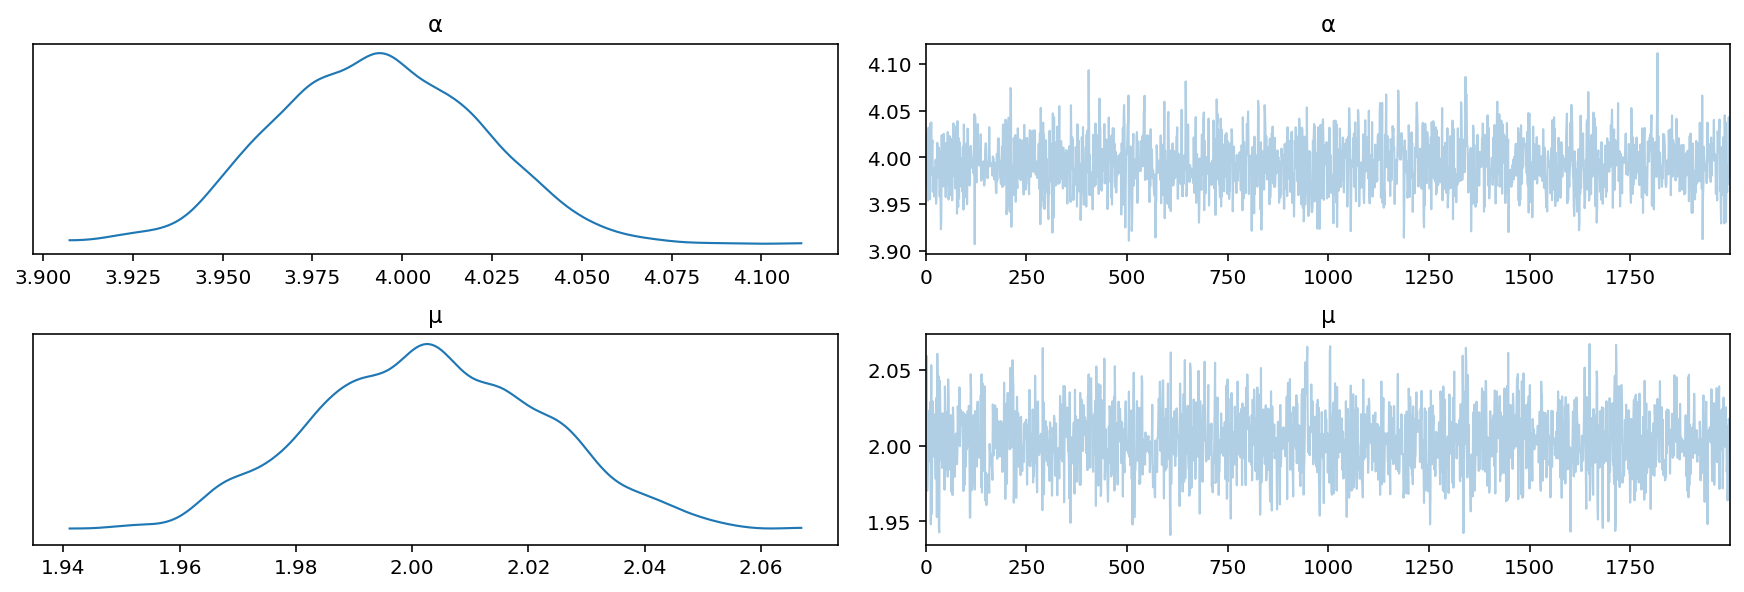

In [8]:
_ = pm.plot_trace(posterior)

In [9]:
posterior.to_dict()["posterior"]["α"].mean(), posterior.to_dict()["posterior"]["µ"].mean()

/Users/larryshamalama/anaconda3/envs/pymc3-dev-py38/lib/python3.8/site-packages/arviz/data/inference_data.py:436: UserWarning: The attributes are not same for all groups. Considering only the first group `attrs`
  warnings.warn(


(3.9930828791135875, 2.0032292346036)